In [1]:
%matplotlib inline
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

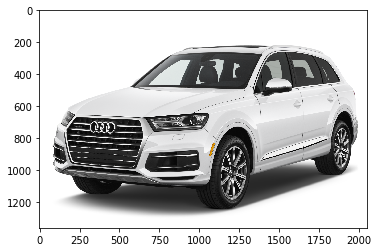

In [2]:
filename = './audi_q7/000001.png'
img = mpimg.imread(filename)
plt.imshow(img)

In [3]:
# hyper parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100
y_data = [[1,0]]

In [4]:
tf.set_random_seed(777)
png_data = tf.placeholder(dtype=tf.string)
filename_queue = tf.train.string_input_producer([filename])
image_reader = tf.WholeFileReader()
_, image_file = image_reader.read(filename_queue)

In [5]:
decode_image = tf.image.decode_png(image_file, channels=3, name='decode_image')
resized_image = tf.image.resize_images(decode_image, [299, 299])

In [6]:
'''
# with tf.Session() as sess:
    # Required to get the filename matching to run.
    tf.global_variables_initializer().run()

    # Coordinate the loading of image files.
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    # Get an image tensor and print its value.
    image_tensor = sess.run([decode_image])
    print(image_tensor)

    # Finish off the filename queue coordinator.
    coord.request_stop()
    coord.join(threads)
    '''

'\n# with tf.Session() as sess:\n    # Required to get the filename matching to run.\n    tf.global_variables_initializer().run()\n\n    # Coordinate the loading of image files.\n    coord = tf.train.Coordinator()\n    threads = tf.train.start_queue_runners(coord=coord)\n\n    # Get an image tensor and print its value.\n    image_tensor = sess.run([decode_image])\n    print(image_tensor)\n\n    # Finish off the filename queue coordinator.\n    coord.request_stop()\n    coord.join(threads)\n    '

In [7]:
class Model:

    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        self._build_net()

    def _build_net(self):
        with tf.variable_scope(self.name):
            # dropout (keep_prob) rate  0.7~0.5 on training, but should be 1
            # for testing
            self.training = tf.placeholder(tf.bool)

            # input place holders
#             self.X = tf.placeholder(tf.float32, [None, 784])
            # img 28x28x1 (black/white), Input Layer
#             X_img = tf.reshape(self.X, [-1, 28, 28, 1])

            self.X = tf.placeholder(tf.float32, [None, 299, 299, 3])
            self.Y = tf.placeholder(tf.float32, [None, 2])

            # Convolutional Layer #1
            conv1 = tf.layers.conv2d(inputs=self.X, filters=32, kernel_size=[3, 3], padding="SAME", activation=tf.nn.relu)
            # Pooling Layer #1
            pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2],
                                            padding="SAME", strides=2)
            dropout1 = tf.layers.dropout(inputs=pool1,
                                         rate=0.7, training=self.training)

            # Convolutional Layer #2 and Pooling Layer #2
            conv2 = tf.layers.conv2d(inputs=dropout1, filters=64, kernel_size=[3, 3],
                                     padding="SAME", activation=tf.nn.relu)
            pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2],
                                            padding="SAME", strides=2)
            dropout2 = tf.layers.dropout(inputs=pool2,
                                         rate=0.7, training=self.training)

            # Convolutional Layer #2 and Pooling Layer #2
            conv3 = tf.layers.conv2d(inputs=dropout2, filters=128, kernel_size=[3, 3],
                                     padding="same", activation=tf.nn.relu)
            pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2],
                                            padding="same", strides=2)
            dropout3 = tf.layers.dropout(inputs=pool3,
                                         rate=0.7, training=self.training)

            # Dense Layer with Relu
            flat = tf.reshape(dropout3, [-1, 128 * 4 * 4])
            dense4 = tf.layers.dense(inputs=flat,
                                     units=625, activation=tf.nn.relu)
            dropout4 = tf.layers.dropout(inputs=dense4,
                                         rate=0.5, training=self.training)

            # Logits (no activation) Layer: L5 Final FC 625 inputs -> 10 outputs
            self.logits = tf.layers.dense(inputs=dropout4, units=2)

        # define cost/loss & optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits=self.logits, labels=self.Y))
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate).minimize(self.cost)

        correct_prediction = tf.equal(
            tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    def predict(self, x_test, training=False):
        return self.sess.run(self.logits,
                             feed_dict={self.X: x_test, self.training: training})

    def get_accuracy(self, x_test, y_test, training=False):
        return self.sess.run(self.accuracy,
                             feed_dict={self.X: x_test,
                                        self.Y: y_test, self.training: training})

    def train(self, x_data, y_data, training=True):
        return self.sess.run([self.cost, self.optimizer], feed_dict={
            self.X: x_data, self.Y: y_data, self.training: training})

In [8]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    input_image = tf.reshape(resized_image, [1, 299, 299, 3])
    input_feed = input_image.eval()

    m1 = Model(sess=sess, name="m1")
    
    print('Learning Started!')

    # train my model
    for epoch in range(training_epochs):
        avg_cost = 0
        c, _ = m1.train(x_data=input_feed, y_data=y_data)
        avg_cost += c / total_batch

        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

    coord.request_stop()
    coord.join(threads)

    print('Learning Finished!')

    # Test model and check accuracy
    # print('Accuracy:', m1.get_accuracy(mnist.test.images, mnist.test.labels))

Learning Started!
INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[Node: input_producer/input_producer_EnqueueMany = QueueEnqueueManyV2[Tcomponents=[DT_STRING], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](input_producer, input_producer/RandomShuffle)]]


FailedPreconditionError: Attempting to use uninitialized value beta1_power
	 [[Node: beta1_power/read = Identity[T=DT_FLOAT, _class=["loc:@m1/conv2d/kernel"], _device="/job:localhost/replica:0/task:0/gpu:0"](beta1_power)]]
	 [[Node: Mean/_35 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_825_Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'beta1_power/read', defined at:
  File "c:\users\dk\appdata\local\programs\python\python35\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\dk\appdata\local\programs\python\python35\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\dk\appdata\local\programs\python\python35\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "c:\users\dk\appdata\local\programs\python\python35\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\dk\appdata\local\programs\python\python35\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "c:\users\dk\appdata\local\programs\python\python35\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "c:\users\dk\appdata\local\programs\python\python35\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "c:\users\dk\appdata\local\programs\python\python35\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\dk\appdata\local\programs\python\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "c:\users\dk\appdata\local\programs\python\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "c:\users\dk\appdata\local\programs\python\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "c:\users\dk\appdata\local\programs\python\python35\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\dk\appdata\local\programs\python\python35\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "c:\users\dk\appdata\local\programs\python\python35\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "c:\users\dk\appdata\local\programs\python\python35\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "c:\users\dk\appdata\local\programs\python\python35\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\dk\appdata\local\programs\python\python35\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\dk\appdata\local\programs\python\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\dk\appdata\local\programs\python\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "c:\users\dk\appdata\local\programs\python\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-e58dab673a15>", line 10, in <module>
    m1 = Model(sess=sess, name="m1")
  File "<ipython-input-7-f34e094119cc>", line 6, in __init__
    self._build_net()
  File "<ipython-input-7-f34e094119cc>", line 60, in _build_net
    learning_rate=learning_rate).minimize(self.cost)
  File "c:\users\dk\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\training\optimizer.py", line 325, in minimize
    name=name)
  File "c:\users\dk\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\training\optimizer.py", line 446, in apply_gradients
    self._create_slots([_get_variable_for(v) for v in var_list])
  File "c:\users\dk\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\training\adam.py", line 122, in _create_slots
    trainable=False)
  File "c:\users\dk\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1679, in variable
    caching_device=caching_device, name=name, dtype=dtype)
  File "c:\users\dk\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\ops\variables.py", line 200, in __init__
    expected_shape=expected_shape)
  File "c:\users\dk\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\ops\variables.py", line 319, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "c:\users\dk\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 1303, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "c:\users\dk\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "c:\users\dk\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "c:\users\dk\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value beta1_power
	 [[Node: beta1_power/read = Identity[T=DT_FLOAT, _class=["loc:@m1/conv2d/kernel"], _device="/job:localhost/replica:0/task:0/gpu:0"](beta1_power)]]
	 [[Node: Mean/_35 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_825_Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [ ]:
X = tf.placeholder(tf.float32, [None, 299*299*3])
Y = tf.placeholder(tf.float32, [none, 3])

In [ ]:
learning_rate = 0.001
training_epochs = 15
batch_size = 1

In [ ]:
X = tf.placeholder(tf.float32, [None, 299*299*3])
X_image = tf.reshoape